In [26]:
import numpy as np 
import pandas as pd 
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sn
from scipy import stats

In [2]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [5]:
df = pd.read_csv("hour.csv")
df = df.drop("instant", axis =1)

In [7]:
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
train = df.iloc[:-1000, :]
test = df.iloc[-1000:, :]
print(df.shape, train.shape, test.shape)

(17379, 16) (16379, 16) (1000, 16)


In [10]:
train_labels = train['cnt'].values
train = train.drop(['dteday', 'cnt', 'casual', 'registered'], axis = 1)
test_labels = test['cnt'].values
test = test.drop(['dteday', 'cnt', 'casual', 'registered'], axis = 1)

In [12]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train.columns], dtype = bool)

categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train.columns], dtype = bool)

numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train.columns], dtype = bool)

In [13]:
transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ]

In [14]:
regressor = linear_model.Lasso(max_iter = 2000)

In [16]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list=transformer_list)),
    ('model_fitting', regressor)
    ]
)

estimator.fit(train, train_labels)
predicted = estimator.predict(test)

print("RMSLE: ", rmsle(test_labels, predicted))
print("MAE: ",  metrics.mean_absolute_error(test_labels, predicted))



RMSLE:  1.3333479197911722
MAE:  110.83327569060327


In [17]:
parameters_grid = {
    'model_fitting__alpha' : [0.1, 1, 2, 3, 4, 10, 30]
}


In [19]:
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring = rmsle_scorer, cv = 4)
grid_cv.fit(train, train_labels)

predicted = grid_cv.best_estimator_.predict(test)

print("RMSLE: ", rmsle(test_labels, predicted))
#print("MAE: ",  metrics.mean_absolute_error(test_labels, predicted))
print("Best params: ", grid_cv.best_params_)

/home/allen2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/allen2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/allen2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/allen2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/allen2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package s

RMSLE:  1.3802457589771415
Best params:  {'model_fitting__alpha': 10}


In [22]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 150)
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = transformer_list)),
    ('model_fitting', regressor)
    ]
)
estimator.fit(train, train_labels)
#metrics.mean_absolute_error(test_labels, estimator.predict(test_data))
print("RMSLE: ", rmsle(test_labels, estimator.predict(test)))

RMSLE:  1.3581414146510238


In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.9, max_depth = 4)

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = transformer_list)),
    ('model_fitting', gbr)
    ]
)
estimator.fit(train, train_labels)
#metrics.mean_absolute_error(test_labels, estimator.predict(test_data))
print("RMSLE: ", rmsle(test_labels, estimator.predict(test)))

RMSLE:  1.3915906329273127


/home/allen2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count Across Working Day')]

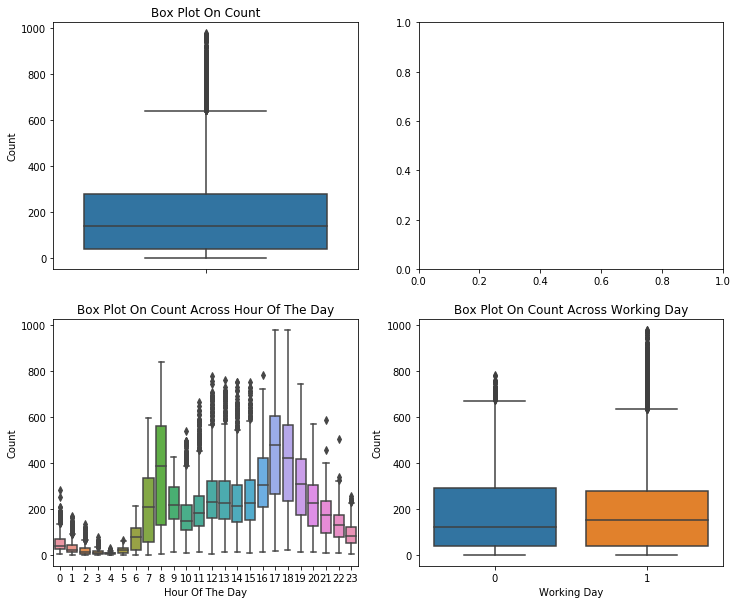

In [32]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data = df,y="cnt",orient="v",ax=axes[0][0])
sn.boxplot(data = df,y="cnt",x="hr",orient="v",ax=axes[1][0])
sn.boxplot(data = df,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

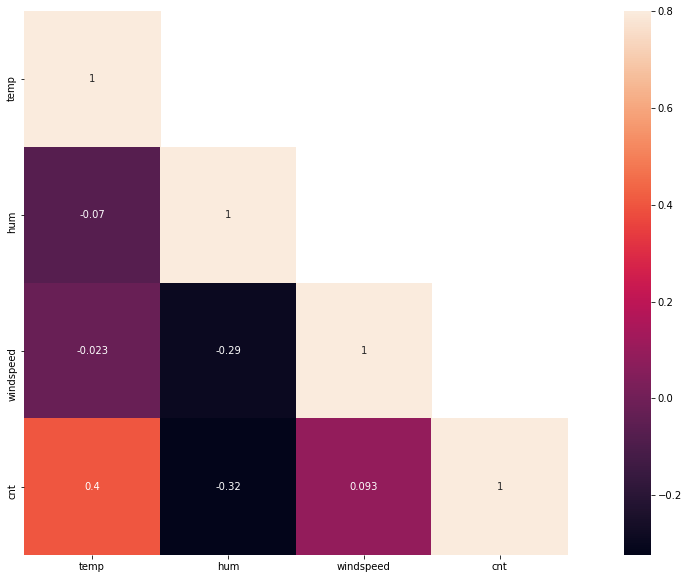

In [34]:
corrMatt = df[["temp","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

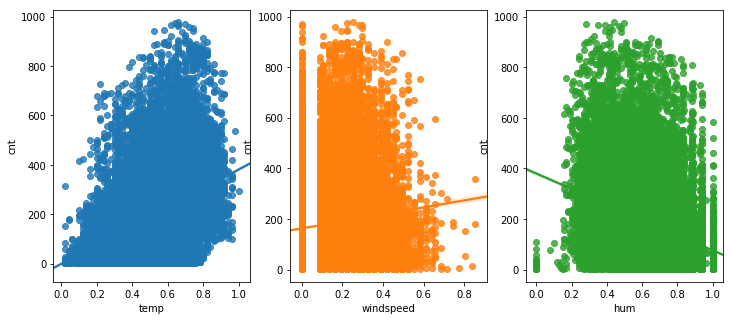

In [35]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="cnt", data=df,ax=ax1)
sn.regplot(x="windspeed", y="cnt", data=df,ax=ax2)
sn.regplot(x="hum", y="cnt", data=df,ax=ax3)